In [2]:
import os

In [3]:
# os.getcwd()

In [4]:
# os.chdir("/home/jovyan/project")

In [5]:
# !sudo apt-get install unrar
# !unrar x Mel128_200_M_P12085.rar

In [6]:
!pip install timm # kaggle doesnt have it installed by default

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.4 MB/s eta 0:00:0000:0100:01


In [7]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [8]:
! pip install torchmetrics
# !pip install -U torch
# ! pip install torchvision  -U
# !pip install -U Pillow
!pip install -U torchsummary
# !pip install -U seaborn

In [9]:
# PyTorch
import warnings

import torch
import torch.nn as nn
from torch import cuda, optim
from torch.utils.data import DataLoader, sampler
from torchmetrics import ConfusionMatrix
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=FutureWarning)

import os

# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt

# Data science tools
import numpy as np
import pandas as pd
import seaborn as sns

# Useful for examining network
from torchsummary import summary

train_on_gpu = cuda.is_available()

%matplotlib inline

In [91]:
model_Type='MaxViT'
feature= 'Mel128'  

In [92]:
PathToDF = "Models.csv"
DataSetName = f"{feature}_200_M_P12085"
rd = np.random.randint(100000)
modelName = f"{model_Type}_{DataSetName}_{rd}_Freez"

RandomState = 42

In [93]:
if not os.path.exists(modelName):
    os.mkdir(modelName)
    os.mkdir(f"{modelName}/model")

# Func

In [88]:
def Save_To_CSV(PathToDF, df):
    if os.path.exists(PathToDF):
        df.to_csv(PathToDF, mode="a", header=False)
    else:
        df.to_csv(PathToDF)

In [14]:
def test(model, test_loader, criterion, CM=False):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        preidcted = np.array([])
        ALL_Labels = np.array([])

        confusionMatrix = np.zeros((7, 7))
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * images.size(0)
            if CM:
                preidcted = np.append(preidcted, pred.to("cpu").numpy())
                ALL_Labels = np.append(ALL_Labels, labels.to("cpu").numpy())

        test_acc = test_acc / len(test_loader.dataset)

        if CM == True:
            confmat = ConfusionMatrix(task="multiclass", num_classes=7)
            confusionMatrix = np.array(
                confmat(
                    torch.tensor(preidcted.astype("int32")),
                    torch.tensor(ALL_Labels.astype("int32")),
                )
            )

        return test_acc, confusionMatrix

# Load Data

In [15]:
torch.manual_seed(RandomState)

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
import warnings

from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [18]:
DataSetName

'Mel128_200_M_P12085'

In [19]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = datasets.ImageFolder(f"/kaggle/input/melspec35k/Mel128_5000_M_P_35000/Mel128_5000_M_P_35000", transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


train_data = int(len(dataset) * 0.8)
valid_data = int((len(dataset) - train_data) / 2)
test_data = int(len(dataset) - train_data - valid_data)

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [train_data, valid_data, test_data]
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=4)

# Train pre trained VGG16

In [20]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda')

In [22]:
# def get_pretrained_model(model_name):

#     if model_name == 'vgg16':
#         model = models.vgg16(pretrained=True)

#         # Freeze early layers
#         # for param in model.parameters():
#         #     param.requires_grad = False

#         n_inputs = model.classifier[6].in_features

#         # Add on classifier
#         model.classifier[6] = nn.Sequential(
#             nn.Linear(n_inputs, 4096), nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(4096, 7), nn.LogSoftmax(dim=1))

#     # Move to gpu and parallelize
#     if train_on_gpu:
#         model = model.to('cuda')

#     return model

In [96]:
def get_pretrained_model(model_name):

    if model_name=="ViT":
        
        model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        for param in model.parameters(): #freeze model
            param.requires_grad = False
        n_inputs = model.head.in_features
        model.head = nn.Sequential(
                    nn.Linear(n_inputs, 512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512, 7)
        )
        
    if model_name=="MaxViT":
        model = timm.create_model("maxvit_tiny_rw_224", pretrained=False,img_size = 224)
#         for param in model.parameters(): #freeze model
#             param.requires_grad = False
        model.head.fc = nn.Linear(512, 7, bias=True)
        
        
        
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        # for param in model.parameters():
        #     param.requires_grad = False

        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 7),
            nn.LogSoftmax(dim=1),
        )
#         model.classifier[6] = nn.Sequential(
#                                             nn.Dropout(0.5),
#                                             nn.Linear(n_inputs, 512),
#                                             nn.ReLU(),
#                                             nn.Linear(512, 7),
#                                             nn.LogSoftmax(dim=1))
        
        # model.classifier[-1] = nn.Sequential(nn.Linear(in_features=4096, out_features=7),nn.LogSoftmax(dim=1))
        # Remove Classifier  Part from VGG16
        # mod = nn.Sequential(*list(vgg16.children())[:-1])

        # Add on classifier
#         model.classifier[6] = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(n_inputs, 4096),
#             nn.ReLU(),
            
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
            
#             nn.Linear(4096, 7),nn.LogSoftmax(dim=1)
#         )
        
#         First Classifier
       
    if model_name == "resnet":
        model = models.resnet101(pretrained=False)

        # Freeze early layers
        # for param in model.parameters():
        #     param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 7),
            nn.LogSoftmax(dim=1),
        )

        # Add on classifier
#         model.fc = nn.Sequential(
#             nn.Linear(n_inputs, 2048),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2048, 7),
#             nn.LogSoftmax(dim=1),
#         )

   
    if model_name == "alexnet":
        model = models.AlexNet()

        # Freeze early layers
        # for param in model.parameters():
        #     param.requires_grad = False

        model.classifier[-1]= nn.Sequential(
            nn.Linear(4096, 7),
            nn.LogSoftmax(dim=1)
        )
        # Add on classifier
#         model.fc = nn.Sequential(
#             nn.Linear(n_inputs, 2048),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2048, 7),
#             nn.LogSoftmax(dim=1),
#         )



    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to("cuda")

    return model

In [97]:
model = get_pretrained_model(model_Type)

In [98]:
# summary(model, input_size=(3, 224, 224), batch_size=32, device="cuda")

In [99]:
model.class_to_idx = dataset.class_to_idx
model.idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}
list(model.idx_to_class.items())[:7]

[(0, 'ar'), (1, 'de'), (2, 'en'), (3, 'es'), (4, 'fr'), (5, 'it'), (6, 'pt')]

In [100]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name,
    max_epochs_stop=3,
    n_epochs=20,
    print_every=1,
    scheduler=None
):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_acc_max = 0

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f"Model has been trained for: {model.epochs} epochs.\n")
    except:
        model.epochs = 0
        print(f"Starting Training from Scratch.\n")

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()
        
        if scheduler!=None:
            scheduler.step()
            print(f"LR : {scheduler.get_lr()}")

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.",
                end="\r",
            )
      

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}"
                    )
                    print(
                        f"\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%"
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # if valid_acc > valid_acc_max:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_acc_max = valid_acc
                    # valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc_max:.2f}%"
                        )
                        total_time = timer() - overall_start
                        print(
                            f"{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch."
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                "train_loss",
                                "valid_loss",
                                "train_acc",
                                "valid_acc",
                            ],
                        )
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%"
    )
    print(
        f"{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch."
    )
    # Format history
    history = pd.DataFrame(
        history, columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]
    )
    return model, history

## optim and loss

In [101]:
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to("cuda")
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.head.parameters(), lr=0.01)

# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.97)

In [102]:
# rd= np.random.randint(100000)
# modelName= f"VGG_{DataSetName}_{rd}"

model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name=f"{modelName}/model/{modelName}.pt",
    max_epochs_stop=6,
    n_epochs=100,
    print_every=1
)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 374.11 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7705 	Validation Loss: 1.6068
		Training Accuracy: 36.06%	 Validation Accuracy: 42.06%
Epoch: 1	100.00% complete. 373.73 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.7322 	Validation Loss: 1.6332
		Training Accuracy: 38.92%	 Validation Accuracy: 42.54%
Epoch: 2	100.00% complete. 373.59 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.6885 	Validation Loss: 1.5729
		Training Accuracy: 40.41%	 Validation Accuracy: 42.60%
Epoch: 3	100.00% complete. 373.68 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.6744 	Validation Loss: 1.7165
		Training Accuracy: 40.91%	 Validation Accuracy: 40.23%
Epoch: 4	100.00% complete. 373.94 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.6688 	Validation Loss: 1.5891
		Training Accuracy: 41.49%	 Validation Accuracy: 44.06%
Epoch: 5	100.00% complete. 373.92 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.6448 	Vali

# Test

In [1]:
test_acc, CM_Test = test(model.cuda(), test_loader, criterion, True)
print(
    f"The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset"
)

train_acc, CM_Train = test(model.cuda(), train_loader, criterion, True)
# train_acc,CM_Train = train(model.cuda(), train_loader, criterion, True)
print(
    f"The model has achieved an accuracy of {100 * train_acc:.2f}% on the trian dataset"
)

NameError: name 'test' is not defined

In [48]:
best_Result = history[history["valid_acc"] == history["valid_acc"].max()]
Models_Results = {
    "Model_Path": [modelName],
    "DataSetName": [DataSetName],
    "vali_acc_Best_Eb": [best_Result.valid_acc.values[0]],
    "train_acc": [train_acc],
    "test_acc": [test_acc],
    "CM_Test": [str(np.array(CM_Test).reshape(7 * 7).tolist())],
    "CM_Train": [str(np.array(CM_Train).reshape(7 * 7).tolist())],
}

In [49]:
Save_To_CSV(PathToDF, pd.DataFrame.from_dict(Models_Results))

In [103]:
modelName

'MaxViT_Mel128_200_M_P12085_16206_Freez'

In [50]:
def PLot_Model_Results(history,Title,Acc=True,Saving=True,Path_save=""):
    """plot Model accuracy and losse over epochs 
        Acc = True  plot Accuract garaph also
    """
    plt.figure(figsize=(10,6))

    if Acc==True:
        plt.plot(history["train_acc"])
        plt.plot(history["valid_acc"])
        plt.title(Title)
        plt.ylabel(f'Accuracy')
        plt.xlabel('epoch')
        plt.legend([f'train Accuracy', f'validation Accuracy'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()
    else :
        plt.plot(history['train_loss'])
        plt.plot(history['valid_loss'])
        plt.title(Title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'test loss'], loc='upper left')
        if Saving==True:
            plt.savefig(f"{Path_save}/{Title}.jpg")
        plt.show()


Save the History

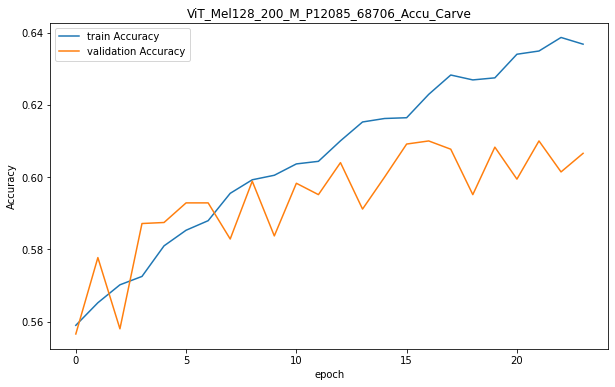

In [51]:
PLot_Model_Results(history,
                   Title=f"{modelName}_Accu_Carve",
                   Acc= True,
                   Saving=True,
                   Path_save=f"{modelName}" )

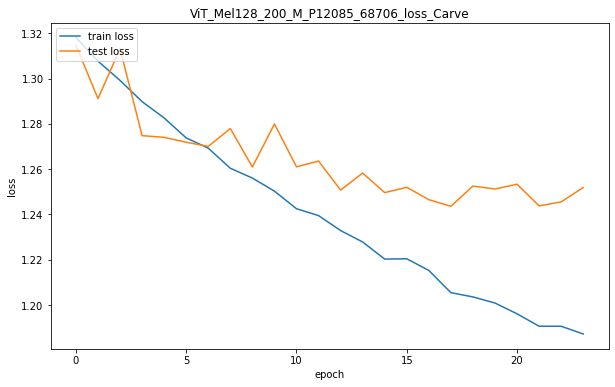

In [52]:
PLot_Model_Results(history,
                   Title=f"{modelName}_loss_Carve",
                   Acc= False,
                   Saving=True,
                   Path_save=f"{modelName}" )

In [53]:
# gih = pd.read_csv("test2.csv",converters={'a': pd.eval})

In [54]:
def Error__anaylsis(model, data_loader):

    # Calcaulte predicted
    preidcted = np.array([])
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, pred = torch.max(outputs, dim=1)
            preidcted = np.append(preidcted, pred.to("cpu").numpy())

    # Get the True labels, and files names
    indices = data_loader.dataset.indices
    Labels_and_paths = np.array(data_loader.dataset.dataset.imgs)[indices]
    img_paths = Labels_and_paths[:, 0]
    true_labels = Labels_and_paths[:, 1].astype("int")

    # Get classes
    classes = data_loader.dataset.dataset.class_to_idx.keys()

    return preidcted, true_labels, classes, img_paths

In [55]:
preidcted, true_labels, classes, img_paths = Error__anaylsis(model, test_loader)

In [56]:
img_names = [x.split("/")[-1] for x in img_paths]
img_names = [x.split(".")[0] + ".wav" for x in img_names]

In [57]:
# source https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
import matplotlib.pyplot as plt
import numpy as np

class PLot_CR():
    def show_values(self, pc, fmt="%.2f", **kw):
        '''
        Heatmap with text in each cell with matplotlib's pyplot
        Source: https://stackoverflow.com/a/25074150/395857 
        By HYRY
        '''
        pc.update_scalarmappable()
        ax = pc.axes
        #ax = pc.axes# FOR LATEST MATPLOTLIB
        #Use zip BELOW IN PYTHON 3
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


    def cm2inch(self, *tupl):
        '''
        Specify figure size in centimeter in matplotlib
        Source: https://stackoverflow.com/a/22787457/395857
        By gns-ank
        '''
        inch = 2.54
        if type(tupl[0]) == tuple:
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)


    def heatmap(self, AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
        '''
        Inspired by:
        - https://stackoverflow.com/a/16124677/395857 
        - https://stackoverflow.com/a/25074150/395857
        '''

        # Plot it out
        fig, ax = plt.subplots()    
        #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
        c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

        # put the major ticks at the middle of each cell
        ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
        ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

        # set tick labels
        #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
        ax.set_xticklabels(xticklabels, minor=False)
        ax.set_yticklabels(yticklabels, minor=False)

        # set title and x/y labels
        plt.title(title, y=1.25)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)      

        # Remove last blank column
        plt.xlim( (0, AUC.shape[1]) )

        # Turn off all the ticks
        ax = plt.gca()    
        for t in ax.xaxis.get_major_ticks():
            t.tick1line.set_visible(False)
            t.tick2line.set_visible(False)
        for t in ax.yaxis.get_major_ticks():
            t.tick1line.set_visible(False)
            t.tick2line.set_visible(False)

        # Add color bar
        plt.colorbar(c)

        # Add text in each cell 
        self.show_values(c)

        # Proper orientation (origin at the top left instead of bottom left)
        if correct_orientation:
            ax.invert_yaxis()
            ax.xaxis.tick_top()       

        # resize 
        fig = plt.gcf()
        #fig.set_size_inches(cm2inch(40, 20))
        #fig.set_size_inches(cm2inch(40*4, 20*4))
        fig.set_size_inches(self.cm2inch(figure_width, figure_height))



    def plot_classification_report(self, classification_report, classes_names, number_of_classes=7, title='Classification report ', cmap='RdYlGn', save_path="", save=False   ):
        '''
        Plot scikit-learn classification report.
        Extension based on https://stackoverflow.com/a/31689645/395857 
        '''
        lines = classification_report.split('\n')

        #drop initial lines
        lines = lines[2:]

        classes = []
        plotMat = []
        support = []
        class_names = []
        for line in lines[: number_of_classes]:
            t = list(filter(None, line.strip().split('  ')))
            if len(t) < 4: continue
            classes.append(t[0])
            v = [float(x) for x in t[1: len(t) - 1]]
            support.append(int(t[-1]))
            class_names.append(t[0])
            plotMat.append(v)


        xlabel = 'Metrics'
        ylabel = 'Classes'
        xticklabels = ['Precision', 'Recall', 'F1-score']
        yticklabels = ['{0} ({1})'.format(classes_names[idx], sup) for idx, sup  in enumerate(support)]
        figure_width = 10
        figure_height = len(class_names) + 3
        correct_orientation = True
        self.heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
        
        if save == True:
            plt.savefig(f"{save_path}/{title}.jpg")
            
        plt.show()



In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Error_anaylsis():
    def __init__(self, y_true, y_pred, classes, PathToSavePLots = "", Df_Path="", file_names= None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.classes = classes
        self.save_path = PathToSavePLots
        self.Df_Path=Df_Path
        self.file_names=file_names
        self.caculted_TF_DF=False
        self.TF_DF= None
    
    def CM(self, plotTitle, Saving=True):
        """Plot the confusion Matrix
            Paramters :

            plotTitle(str): The plot title the diffule "CR"

            Saving(Bool): save the plot in the given path the diffult False
        """
        result = confusion_matrix(self.y_true,  self.y_pred)
        df_cm = pd.DataFrame(result, index = [i for i in self.classes],
                      columns = [i for i in self.classes])
        plt.figure(figsize = (10,7))
        plt.title(plotTitle)
        sns.heatmap(df_cm, annot=True, fmt='g')
        
        if Saving ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()

        
    def CR(self, printing=True, ploting=False, plotTitle="CR", Saving=False ):
        """Calculating the Classification Report and plot it  
        
            Paramters :
            
            printing(Bool): Print the CR the Deffult True
            
            ploting(Bool): Ploting the the CR diffulte False
            
            plotTitle(str): The plot title the diffulte "CR"
            
            Saving(Bool): save the plot in the given path the diffult False
        """
        cr = classification_report(self.y_true,  self.y_pred, target_names=self.classes)
        if printing == True:
            print(cr)
            
        if ploting == True:
            PLot_CR().plot_classification_report(cr, self.classes, 7, title=plotTitle, save = True, save_path=self.save_path )
   
    
    def Create_TF_DF(self):
        if(self.file_names)==None:
            raise Exception("you shouid enter files names in the order of the predictions")
        
        True_OF_False = (self.y_pred == self.y_true).astype(int).tolist()
        self.TF_DF = pd.DataFrame({"filename" : self.file_names, "T_F" : True_OF_False})
        
        Originaldf = pd.read_csv(self.Df_Path)
        Originaldf =  Originaldf[Originaldf["filename"].isin(self.TF_DF["filename"].values)]
        
        self.TF_DF = pd.merge( Originaldf, self.TF_DF, on=["filename"])
        self.caculted_TF_DF =True
        
    
    def All_Length_disPlot(self, PLotTorF=1, plotTitle="Length_disPlot", saveing=False, plotType="kde"):
        """Plot distripution plot for the audios duiorations all for all languages in one figure
        
            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffulte False

            plotType(str): the ploting type for displot {“hist”, “kde”, “ecdf”} the diffulte kde
        """
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        sns.displot(data = self.TF_DF[self.TF_DF.T_F==PLotTorF], x="length", kind=plotType, hue="language" ).set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
            plt.show()  
            
            
            
            
    def Individually_Length_disPlot(self, PLotTorF=1, plotTitle="Length_disPlot", saveing=False, plotType="kde", langs="All", Train=False):
        """Plot distripution plot for the audios duiorations all for each language in langs in one figure for each language 
        
            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffulte False

            plotType(str): the ploting type for displot {“hist”, “kde”, “ecdf”} the diffulte kde
            
            langs(list): the languages for ploting the diffulte all which wil plot all languages
            
            Train(Bool): Include the train data into the graph or not diffult False
        """
        
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        if langs =="All":
            langs= [lang for lang in self.classes]
            
        if PLotTorF==1:
            Legend_Name= "True Predicted"
        else:
            Legend_Name= "False Predicted"
            
        if Train==True:
            Traindf = pd.read_csv(self.Df_Path)
            
            
        for lang in langs:
            dataPredicted = self.TF_DF[(self.TF_DF.T_F==PLotTorF) & (self.TF_DF.language==lang)]
            dataTest = self.TF_DF[self.TF_DF.language==lang]
            dataTrain = Traindf[Traindf.language==lang]

            if Train==True:
                ax = dataTrain.length.plot(kind = 'density',  alpha = 0.9, color="b", label = "Train", linewidth=2)
                
            ax = dataTest.length.plot(kind = 'density',  alpha = 0.4,color="g", label = 'Test', linewidth=4)
            ax = dataPredicted.length.plot(kind = 'density',  alpha = 0.7, color="r", label = Legend_Name, linewidth=2)

            
            ax.set(xlabel="Length", ylabel="density")
            ax.set(title=f"{plotTitle}_{lang}")
            ax.legend(fontsize=8)
            if saveing ==True:
                plt.savefig(f"{self.save_path}/{plotTitle}_{lang}.jpg")
            plt.show()
            
            
    def All_Speakers_disPlot(self, PLotTorF=1, plotTitle="Speakers_disPlot", saveing=False, Train=False, TopK=5):
        """Plot barPLot figure shows the most Speakers the model get them true of false based on the passed paramters
        
            PLotTorF(int): get the most Speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1
            
            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffult False

            Train(Bool): Include the train data into the graph or not diffult False
            
            TopK(int): get the top k speakers diffult 5
            
        """
        
        
        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
            
        if PLotTorF==1:
            Legend_Name= "True Predicted"
            color = "forestgreen"
        else:
            Legend_Name= "False Predicted"
            color = "darkred"
   
        All_Test = self.TF_DF.groupby("speaker")["T_F"].agg("count")
        Predicted = self.TF_DF[self.TF_DF["T_F"]==PLotTorF].groupby("speaker")["T_F"].agg("count").sort_values(ascending=False)[0:TopK]   
        Renamed_Speakrs = [i+1 for i in range(len(Predicted))]
        
        if Train==False:
             # Test
            DF_ = pd.DataFrame(
                     data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" :  All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })
            

            # Predicted
            DF_ = pd.concat([DF_ ,
                        pd.DataFrame(data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])
            
            ax = sns.barplot(data=DF_, x="Renamed_Speakrs", y="values", hue="type",  ci=None, errwidth=0, palette=["gray", color])
            
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.set(xlabel="Speaker", ylabel="Count")
            ax.set(title=plotTitle)
            
            
        else:
            Traindf = pd.read_csv(self.Df_Path)
            TrainSPCount = Traindf.groupby("speaker")["speaker"].agg("count")
            
            # Train
            DF_ = pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : TrainSPCount[Predicted.index].values,
                         "type": ["Train"] *len(TrainSPCount[Predicted.index].values) })
            
            
            # Test
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })])
            
            
            # Predicted
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Renamed_Speakrs": Renamed_Speakrs ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])
            
            
            ax = sns.barplot(data=DF_, x="Renamed_Speakrs", y="values", hue="type",  ci=None, errwidth=0, palette=["C0", "gray", color])
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.bar_label(ax.containers[2])


            ax.set(xlabel="Speaker", ylabel="Count")
            ax.set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()
        
        
        

    def All_Gender_disPlot(self, PLotTorF=1, plotTitle="Speakers_disPlot", saveing=False, Train=False, Gander="All"):
        """Plot barPLot figure shows the most speakers the model get them true of false based on the passed paramters

            PLotTorF(int): get the most speakers the model get them true if it is ==1 or the most flase ==0 diffult ==1

            plotTitle(str): The plot title the diffulte "Speakers_disPlot"

            saveing(Bool): save the plot in the given path the diffult False

            Train(Bool): Include the train data into the graph or not diffult False
            
            Gander(list): determine the ploted gender diffult value is all == ['n', 'm', 'f']
        """


        if self.caculted_TF_DF==False:
            self.Create_TF_DF()
        if PLotTorF==1:
            Legend_Name= "True Predicted"
            color = "forestgreen"
        else:
            Legend_Name= "False Predicted"
            color = "darkred"
         
        if  Gander=="All":
            Gander =['n', 'm', 'f']
            
            

        All_Test = self.TF_DF.groupby("gender")["T_F"].agg("count")
        Predicted = self.TF_DF[self.TF_DF["T_F"]==PLotTorF].groupby("gender")["T_F"].agg("count").sort_values(ascending=False) 
        Gender_Name = [i for i in Predicted.index]
        
        # PLot Test and Predicted
        if Train==False:
             # Test
            DF_ = pd.DataFrame(
                     data = { "Gender": Gender_Name ,
                         "values" :  All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })


            # Predicted
            DF_ = pd.concat([DF_ ,
                        pd.DataFrame(data = { "Gender": Gender_Name ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])

            DF_ = DF_[DF_.Gender.isin(Gander)] 
            print(DF_)
            ax = sns.barplot(data=DF_, x="Gender", y="values", hue="type",  ci=None, errwidth=0, palette=["gray", color])

            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.set(xlabel="Gender", ylabel="Count")
            ax.set(title=plotTitle)

        # PLot Train, Test and Predicted
        else:
            Traindf = pd.read_csv(self.Df_Path)
            TrainSPCount = Traindf.groupby("gender")["gender"].agg("count")

            # Train
            DF_ = pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : TrainSPCount[Predicted.index].values,
                         "type": ["Train"] *len(TrainSPCount[Predicted.index].values) })


            # Test
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : All_Test[Predicted.index].values,
                         "type": ["Test"] *len(Predicted[Predicted.index].values) })])


            # Predicted
            DF_ = pd.concat([DF_ ,pd.DataFrame(
                        data = { "Gender": Gender_Name ,
                         "values" : Predicted.values,
                         "type": [Legend_Name] *len(Predicted.values) })])

            DF_ = DF_[DF_.Gender.isin(Gander)] 
            ax = sns.barplot(data=DF_, x="Gender", y="values", hue="type",  ci=None, errwidth=0, palette=["C0", "gray", color])
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            ax.bar_label(ax.containers[2])


            ax.set(xlabel="Gender", ylabel="Count")
            ax.set(title=plotTitle)
        if saveing ==True:
            plt.savefig(f"{self.save_path}/{plotTitle}.jpg")
        plt.show()


In [59]:
# from Error_Analsis import Error_anaylsis as d

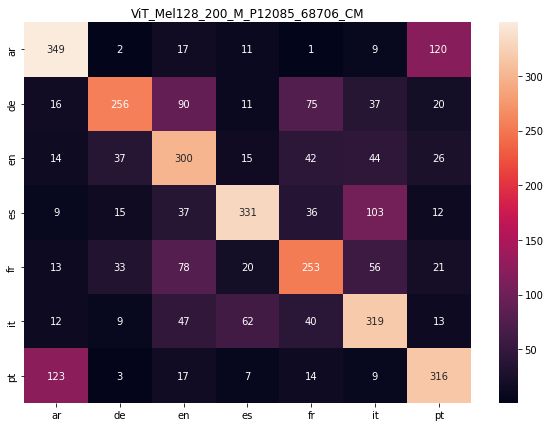

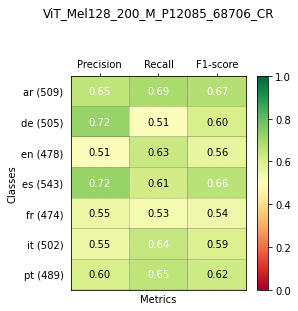

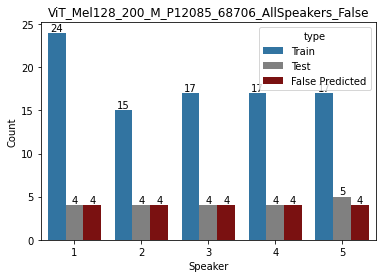

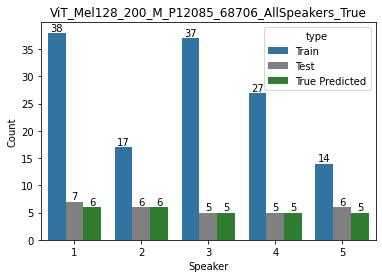

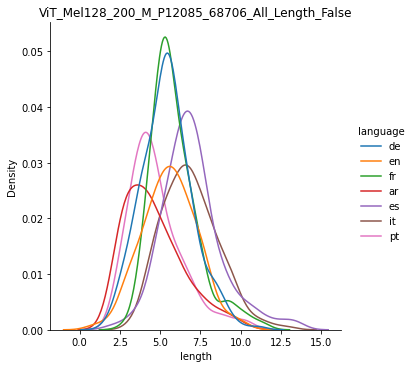

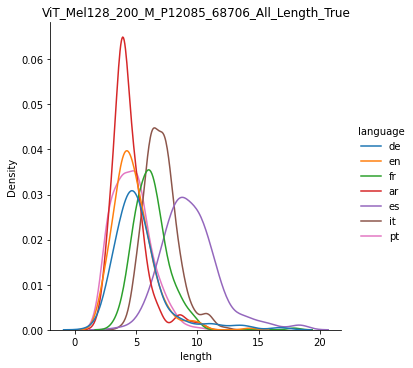

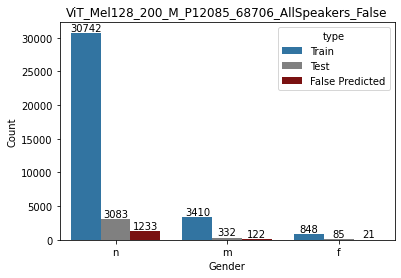

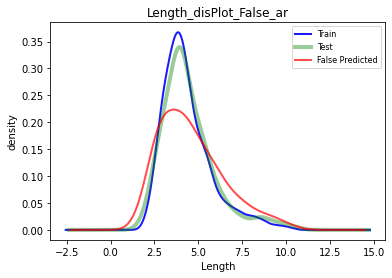

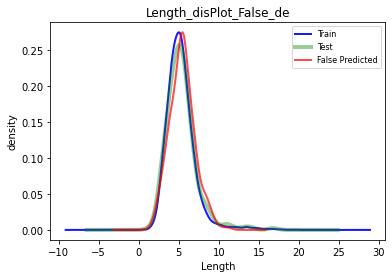

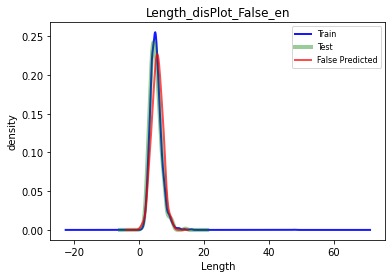

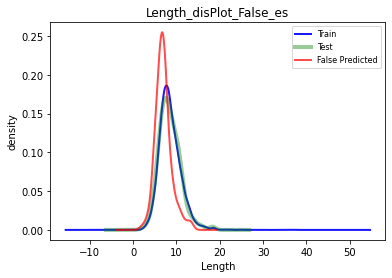

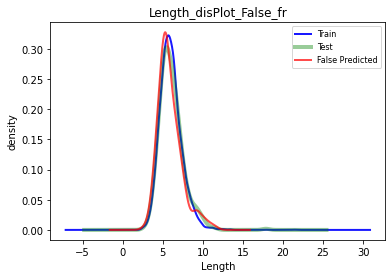

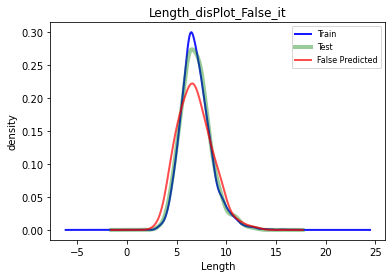

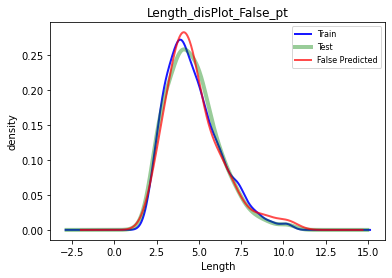

In [60]:
EA =Error_anaylsis(
    true_labels,
    preidcted,
    list(classes),
    modelName,
    Df_Path="/kaggle/input/melspec35k/sample5000.csv",
    file_names=img_names,
)
EA.CM(plotTitle=f"{modelName}_CM", Saving=True)
EA.CR(plotTitle=f"{modelName}_CR",printing=False, ploting=True, Saving=True)

EA.All_Speakers_disPlot(PLotTorF=0,  plotTitle=f"{modelName}_AllSpeakers_False", saveing=True, Train=True, TopK=5)
EA.All_Speakers_disPlot(PLotTorF=1,  plotTitle=f"{modelName}_AllSpeakers_True", saveing=True, Train=True, TopK=5)


EA.All_Length_disPlot(PLotTorF=0, plotTitle=f"{modelName}_All_Length_False", saveing=True, plotType="kde")
EA.All_Length_disPlot(PLotTorF=1, plotTitle=f"{modelName}_All_Length_True", saveing=True, plotType="kde")

EA.All_Gender_disPlot(PLotTorF=0,  plotTitle=f"{modelName}_AllSpeakers_False", saveing=True, Train=True, Gander= "All")


EA.Individually_Length_disPlot(
    PLotTorF=0,
    plotTitle="Length_disPlot_False",
    saveing=True,
    plotType="kde",
    langs="All",
    Train=True
)

In [61]:
from IPython.display import FileLink
import shutil

shutil.make_archive(modelName, 'zip', modelName)
FileLink(f"{modelName}.zip")


/kaggle/working/ViT_Mel128_200_M_P12085_68706.zip

In [62]:
FileLink(f"Models.csv")

/kaggle/working/Models.csv

###############################################
##############################################

In [99]:
model.load_state_dict(torch.load("vgg16_Mel128_200_M_P12085_67915/model/vgg16_Mel128_200_M_P12085_67915.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'vgg16_Mel128_200_M_P12085_67915/model/vgg16_Mel128_200_M_P12085_67915.pt'

# Try 2

In [25]:
from torch.nn import functional as F
from torch import topk
import cv2

In [85]:
image = cv2.imread("Mel128_200_M_P12085/ar/ar-f-0-19-CV.jpg")
image = cv2.resize(image, (224,224))

height, width, _ = image.shape

# transforms = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.Resize((224, 224)),
#      transforms.ToTensor()
 
    
#     ])

In [86]:
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [92]:
def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.7
        # put class label text on the result
        cv2.putText(result, str(int(class_idx[i])), (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # cv2.imshow('CAM', result/255.)
        # cv2.waitKey(0)
        cv2.imwrite(f"CAM_{save_name}.jpg", result)

In [93]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('features').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

In [94]:
# apply the image transforms
image_tensor = transforms(image)
# add batch dimension
image_tensor = image_tensor.unsqueeze(0).cpu()
# forward pass through model
outputs = model(image_tensor)
# get the softmax probabilities
probs = F.softmax(outputs).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

In [95]:
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

In [96]:
save_name="Test"
show_cam(CAMs, width, height, image, class_idx, save_name)

1


In [20]:
 modasel = models.resnet101(pretrained=True)

    

In [36]:
import time

In [40]:
from zipfile import ZipFile


'/kaggle/working/resnet_Mel128_200_M_P12085_80047_2048.zip'

In [83]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,0.026928,0.643096,0.991286,0.853143
1,0.008211,0.717310,0.997857,0.850000
2,0.004250,0.749596,0.999107,0.848286
3,0.002993,0.811740,0.999286,0.850571
4,0.003588,0.885823,0.999250,0.840857
5,0.003417,0.866467,0.999000,0.851429
6,0.002515,0.918190,0.999393,0.850000


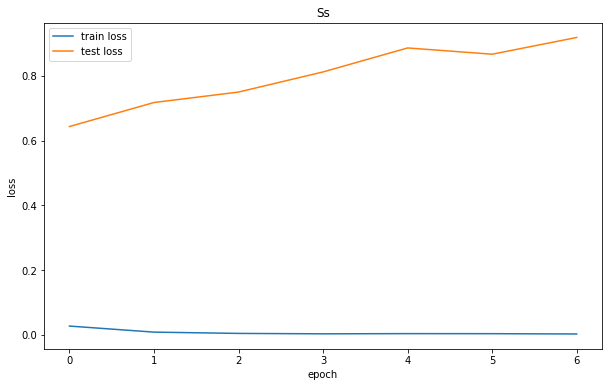

In [62]:
 ui = models.AlexNet()


In [63]:
ui

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [65]:
ui

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [79]:
model = timm.create_model("maxvit_tiny_rw_224", pretrained=False,img_size = 224)


In [ ]:
model

In [84]:
model.head

ClassifierHead(
  (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (flatten): Identity()
)